# GMU Firealarm Map Making Demo
### Author: Tayven Stover

#### Future Ideas:
 - We could have a 'providers' dropdown where the user can select their provider to see data from different providers.

In [1]:
from ipywidgets import widgets
from GMU_Modules import plotting
from GMU_Modules import firealarm_processing
from GMU_Modules import ui_elements
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from datetime import datetime

In [2]:
# Gather Data for area of study (New York, New York)
# Year-month-day
start_date = '2023-06-04' # Start date of canada fire
end_date = '2023-06-10' # Max range 7 days
sensor_ids = [60863, 135024, 174545]

# API uses
bounding_box = firealarm_processing.retrieve_bounding_box('New York', 'New York') # Implements our Insitue county/state endpoint.
sensor_readings = firealarm_processing.retrieve_sensor_readings([start_date, end_date], sensor_ids)


['60863', '135024', '174545']


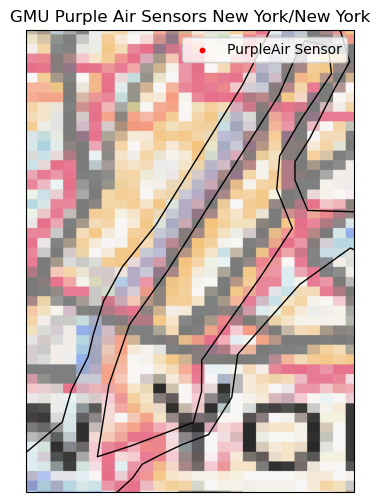

In [3]:
plotting.map_points([], title='GMU Purple Air Sensors New York/New York', bounds=bounding_box, legend=True)
print([str(id) for id in sensor_ids])

<Axes: title={'center': 'PM2.5 Readings State / County [2022-07-01 to 2022-07-03]'}, xlabel='Date', ylabel='PM2.5: µg/m³'>

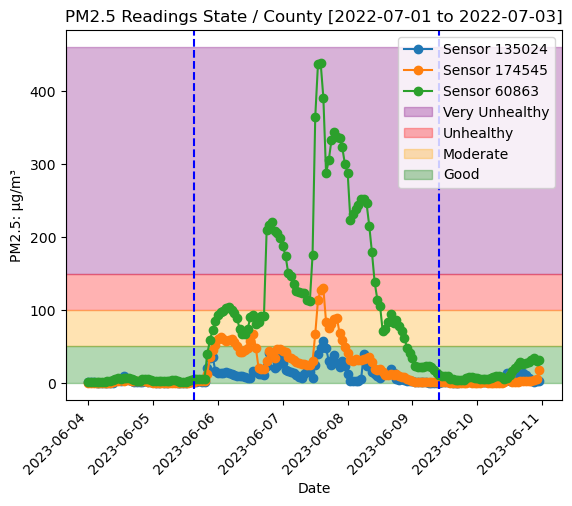

<Figure size 1000x1500 with 0 Axes>

In [7]:
# Plots the sensor readings in new york from 2023-06-04 to 2023-06-10
# This was when New York was experiencing the worst smoke from the 2023 Canada fires.
# The highlighted point on this plot indicates the time range of the smoke event.
plotting.plot_sensor_readings(sensor_readings, focus_range = [datetime(2023,6,5,15), datetime(2023,6,9,10)])

# Example UI Implementation Using GMU's Insitu APIs

This code cell demonstrates a sample user interface tool that leverages the capabilities of GMU's Insitu APIs to provide an interactive and responsive experience. Through this implementation, users can effectively utilize the robust features offered by the APIs within a streamlined UI environment.

They default area / date of study is my hometown medford oregon 9/7/2020 - 9/10/2020 during the alemeda fire.

https://wildfiretoday.com/tag/almeda-drive-fire/


In [5]:
LOCATION_PATH = 'State_County_Data'

def process_location(location):
    keys = [key.strip() for key in location.split('/')]
    return keys[0], keys[1]

def process_date(data):
    keys = [key.strip() for key in data.split('/')]
    year, month, day = keys[2], keys[1], keys[0]
    date = f'{year}-{month}-{day}'

    return date

def load_states():
    STATE_PATH = f'{LOCATION_PATH}/us_states.csv'

    sorted_states = pd.read_csv(STATE_PATH).sort_values('NAME')

    return sorted_states[['NAME', 'STATEFP']].values.tolist()

def load_counties(statefp):
    COUNTY_PATH = f'{LOCATION_PATH}/us_counties.csv'

    counties = pd.read_csv(COUNTY_PATH)
    state_counties = counties[counties['STATEFP'] == statefp].sort_values('NAME')

    return state_counties['NAME'].values.tolist()


In [6]:
# Stores UI data not needed for use of api or plots
class AppData: # So the user doesn't have to re-enter the same data every time
    def __init__(self):
        # User states
        self.start_date = '07/09/2020'
        self.end_date = '14/09/2020'
        self.state = None
        self.county = None
        self.location = ''
        self.selected_sensors = ()

        # Data gathered from APIs
        self.sensor_data = None
        self.bounding_box = None

app_data = AppData() # Initialize data object

start_date_box, end_date_box, state_dropdown, county_dropdown, gather_data_button = ui_elements.gather_data_elements()

def gather_data_button_click(e):
    # Widget state handling
    app_data.start_date = start_date_box.value
    app_data.end_date = end_date_box.value
    app_data.state = state_dropdown.value
    app_data.county = county_dropdown.value
    state_name = next((name for name, value in state_dropdown.options if value == state_dropdown.value), None)
    app_data.location = f'{state_name}/{county_dropdown.label}'
    clear_output()
    display_widgets('make_plot')

    # Gather data from APIs
    state, county = process_location(app_data.location)
    bounding_box = firealarm_processing.retrieve_bounding_box(state, county)
    sensor_data = firealarm_processing.retrieve_sensors(bounding_box, process_date(app_data.start_date))

    # Store data in app data so user can select which sensors they would like to plot and read data from.
    app_data.bounding_box = bounding_box
    app_data.sensor_data = [(data['latitude'], data['longitude'], data['platform_id']) for data in sensor_data]
    # Max SID len = 8, Max Latitude len = 10, Max Longitude len = 11
    sensor_select.options = [(f'Sensor ID: {str(data[2]) + " "* (8 - len(str(data[2])))}| Latitude: {data[0]} | Longitude: {data[1]}',
                              app_data.sensor_data.index(data)) for data in app_data.sensor_data]
    
gather_data_button.on_click(gather_data_button_click)

sensor_select, back_to_gather_data_button, make_plot_button = ui_elements.make_plot_elements()

def make_plot_button_click(e):
    app_data.selected_sensors = sensor_select.value
    clear_output()
    display_widgets('view_plot')
    state, county = process_location(app_data.location)

    plotting.plot_map_and_sensor_readings(firealarm_processing.retrieve_sensor_readings([process_date(app_data.start_date),
                                                                                        process_date(app_data.end_date)],
                        [app_data.sensor_data[app_data.selected_sensors[i]][2] for i in range(len(app_data.selected_sensors))]),
                        [app_data.sensor_data[i] for i in app_data.selected_sensors],
                        title=f'GMU Purple Air Sensors {state}/{county}', bounds=app_data.bounding_box, legend=True)

def back_to_gather_data_button_click(e):
        clear_output()
        display_widgets('gather_data')

make_plot_button.on_click(make_plot_button_click)
back_to_gather_data_button.on_click(back_to_gather_data_button_click)


def view_plot_home_button_click(e):
    clear_output()
    display_widgets('gather_data')

def back_to_make_plot_button_click(e):
    clear_output()
    display_widgets('make_plot')

view_plot_home_button, back_to_make_plot_button = ui_elements.view_plot_elements()

view_plot_home_button.on_click(view_plot_home_button_click)
back_to_make_plot_button.on_click(back_to_make_plot_button_click)

def display_widgets(method):
    if method == 'gather_data':
        # Load options for county dropdown
        county_dropdown.options = load_counties(state_dropdown.value)

        # Load possible user states
        start_date_box.value = app_data.start_date
        end_date_box.value = app_data.end_date
        if app_data.state:
            state_dropdown.value = app_data.state

        if app_data.county:
            county_dropdown.value = app_data.county

        # Display widgets
        display(start_date_box)
        display(end_date_box)
        display(state_dropdown)
        display(county_dropdown)
        display(gather_data_button)

    elif method == 'make_plot':
        # Load possible user states
        sensor_select.value = app_data.selected_sensors

        # Display widgets
        display(widgets.Label('Sensors:'))
        display(widgets.Label('- To select a range of sensors: Click on the first sensor,'
                              'then hold \'Shift\' and click on the last sensor in the range.'))
        display(widgets.Label('- To select multiple individual sensors: Hold \'Ctrl\' (or '
                              '\'Cmd\' on Mac) and click on each sensor you want to select.'))
        display(sensor_select)
        display(make_plot_button)
        display(back_to_gather_data_button)

    elif method == 'view_plot':
        # Display widgets
        display(view_plot_home_button)
        display(back_to_make_plot_button)


display_widgets('gather_data')

Text(value='07/09/2020', description='Date/Start Date:', placeholder='dd/mm/yy')

Text(value='14/09/2020', description='End date:', placeholder='dd/mm/yy')

Dropdown(description='State:', index=40, options=(('Alabama', 1), ('Alaska', 2), ('American Samoa', 60), ('Ari…

Dropdown(description='County:', index=14, options=('Baker', 'Benton', 'Clackamas', 'Clatsop', 'Columbia', 'Coo…

Button(description='Gather data', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='Gather data nesce…